In [1]:
import pandas as pd
import numpy as np
import json
import requests
import xmltodict, json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib notebook
import gmaps
import os


In [2]:
#url1 ="https://www.zillow.com/webservice/GetUpdatedPropertyDetails.htm?zws-id=X1-ZWz17giky9jf9n_43hp8&zpid=48749425"
#url2 ="http://www.zillow.com/webservice/GetDeepComps.htm?zws-id=X1-ZWz17giky9jf9n_43hp8&zpid=48749425&count=5"
#url3 ="http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id=X1-ZWz17giky9jf9n_43hp8&address=2114+Bigelow+Ave&citystatezip=Seattle%2C+WA"
url4="http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz17giky9jf9n_43hp8&state=tx&childtype=county"
#url5="http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz17giky9jf9n_43hp8&state=nj&city=jersey&childtype=neighborhood"

In [3]:
#import FEMA data
file1 = "../../Final_Data/DisasterDeclarationsSummaries.csv"
file2 = "../../Final_Data/FEMA_Housing_Assistance_Owners.csv"
disaster_df = pd.read_csv(file1)
housingasst_df = pd.read_csv(file2)

In [4]:
#rename columns
disaster_df.rename(columns = {'disasterNumber':'Disaster'}, inplace = True) 
print(housingasst_df)
print(disaster_df)

       Disaster State             County                      City  Zip Code  \
0          4454    TX   Cameron (County)  BLUETOWN-IGLESIA ANTIGUA     78559   
1          4454    TX   Cameron (County)               BROWNSVILLE     78520   
2          4454    TX   Cameron (County)               BROWNSVILLE     78521   
3          4454    TX   Cameron (County)               BROWNSVILLE     78526   
4          4454    TX   Cameron (County)                    COMBES     78535   
...         ...   ...                ...                       ...       ...   
28336      4394    SC  Marlboro (County)                    MCCOLL     29570   
28337      4394    SC  Marlboro (County)                   SELLERS     29592   
28338      4394    SC  Marlboro (County)                     TATUM     29570   
28339      4394    SC  Marlboro (County)                     TATUM     29594   
28340      4394    SC  Marlboro (County)                   WALLACE     29596   

      Valid Registrations Average FEMA 

In [5]:
#fema_mrg = pd.merge(housingasst_df, disaster_df, on='Disaster')
fema_mrg = pd.merge(left=housingasst_df,right=disaster_df, left_on='Disaster', right_on='Disaster')

print(fema_mrg.head(5))
#incidentType, fyDeclared, Disaster,state,incidentType,

   Disaster State            County                      City  Zip Code  \
0      4454    TX  Cameron (County)  BLUETOWN-IGLESIA ANTIGUA     78559   
1      4454    TX  Cameron (County)  BLUETOWN-IGLESIA ANTIGUA     78559   
2      4454    TX  Cameron (County)  BLUETOWN-IGLESIA ANTIGUA     78559   
3      4454    TX  Cameron (County)               BROWNSVILLE     78520   
4      4454    TX  Cameron (County)               BROWNSVILLE     78520   

  Valid Registrations Average FEMA Inspected Damage  Total Inspected  \
0                   1                          $149                1   
1                   1                          $149                1   
2                   1                          $149                1   
3                  10                          $335                9   
4                  10                          $335                9   

  Total Damage No FEMA Inspected Damage  ... disasterType  incidentType  \
0         $149                        0  

In [6]:
fema_fnl = fema_mrg[["Disaster","incidentType","fyDeclared","state","County", "City", "Zip Code"]]
fema_fnl.dropna(how="any", inplace=True)
fema_fnl.reset_index(drop=True, inplace=True)
fema_no_dups = fema_fnl.drop_duplicates()
len(fema_fnl)

C:\Users\bandi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1480855

In [7]:
abr = fema_fnl[fema_fnl['state'].str.contains('TX')]
fema_tx = abr.drop_duplicates()
fema_tx.head(5)

,Disaster,incidentType,fyDeclared,state,County,City,Zip Code
0,4454,Flood,2019,TX,Cameron (County),BLUETOWN-IGLESIA ANTIGUA,78559
3,4454,Flood,2019,TX,Cameron (County),BROWNSVILLE,78520
6,4454,Flood,2019,TX,Cameron (County),BROWNSVILLE,78521
9,4454,Flood,2019,TX,Cameron (County),BROWNSVILLE,78526
12,4454,Flood,2019,TX,Cameron (County),COMBES,78535


In [8]:
sum_county1 = fema_tx.groupby("County").count().Disaster
sum_incident = fema_tx.groupby("incidentType").count()
sum_fy = fema_tx.groupby("fyDeclared").count()
#um_zip = fema_tx.groupby("Zip Code").count()
print(sum_county1.head(5))
#print(sum_incident.head(5))
#print(sum_fy.head(5))
#rint(sum_zip.head(5))

County
Anderson (County)     6
Angelina (County)     7
Aransas (County)     41
Austin (County)      54
Bastrop (County)     45
Name: Disaster, dtype: int64


In [9]:
#Clean up County Column for FEMA
county_dis = sum_county1.to_frame()
county_dis.reset_index(drop=False, inplace=True)
new = county_dis["County"].str.split(" ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
county_dis["Counties"]= new[0] 
  
# making separate last name column from new data frame 
county_dis["type"]= new[1] 
  
# Dropping old Name columns 
county_dis.drop(columns =["County"], inplace = True) 
  
# df display 

county_dis.head(5)

,Disaster,Counties,type
0,6,Anderson,(County)
1,7,Angelina,(County)
2,41,Aransas,(County)
3,54,Austin,(County)
4,45,Bastrop,(County)


In [10]:
#Request API
#response1 = requests.get(url1).content
#response2 = requests.get(url2).content
#response3 = requests.get(url3).content
response4 = requests.get(url4).content

In [11]:
#convert XML to json

#resp1 = xmltodict.parse(response1)
#resp2 = xmltodict.parse(response2)
#resp3 = xmltodict.parse(response3)
resp4 = xmltodict.parse(response4)

#json.dumps(resp1) 
#json.dumps(resp2)
#json.dumps(resp3)
json.dumps(resp4)
#convert json to Dataframe

#propertydetails_df = pd.DataFrame.from_dict(json_normalize(resp1), orient='columns')
#comps_df = pd.DataFrame.from_dict(json_normalize(resp2), orient='columns')
#searchresults_df = pd.DataFrame.from_dict(json_normalize(resp3), orient='columns')
regionchildren_df = pd.DataFrame.from_dict(json_normalize(resp4), orient='columns')


In [12]:
#propertydetails_df.rename(columns=lambda x: x[55:], inplace=True)
#comps_df.rename(columns=lambda x: x[45:], inplace=True)
#searchresults_df.rename(columns=lambda x: x[30:], inplace=True)
regionchildren_df.rename(columns=lambda x: x[30:], inplace=True)
regionchildren_df.head(5)

,@xsi:schemaLocation,@xmlns:xsi,@xmlns:RegionChildren,request.state,request.childtype,message.text,message.code,response.region.id,response.region.latitude,response.region.longitude,response.subregiontype,response.list.count,response.list.region
0,http://www.zillow.com/static/xsd/RegionChildre...,http://www.w3.org/2001/XMLSchema-instance,http://www.zillow.com/static/xsd/RegionChildre...,tx,county,Request successfully processed,0,54,31.170152,-100.076446,county,254,"[{'id': '1090', 'name': 'Harris County', 'lati..."


In [13]:
#extract child(zipcode) which is a dictionary into a dataframe
region_list = pd.DataFrame(regionchildren_df['response.list.region'][0])
#dropna and reset index
region_list.dropna(how="any", inplace=True)
region_list.reset_index(drop=True, inplace=True)

print(region_list.head(5))

     id            name   latitude   longitude  \
0   978   Dallas County  32.767271  -96.777624   
1    98     Bell County  31.036287  -97.492016   
2   498    Ellis County  32.300758  -96.735228   
3  1827  Johnson County  32.344555  -97.351662   
4  1423   Taylor County  32.302102  -99.890743   

                                    zindex  
0  {'@currency': 'USD', '#text': '122000'}  
1  {'@currency': 'USD', '#text': '116600'}  
2  {'@currency': 'USD', '#text': '121300'}  
3  {'@currency': 'USD', '#text': '122300'}  
4   {'@currency': 'USD', '#text': '99800'}  


In [14]:
#extract USD value from dictionary
region_list["USD($)"] = [d.get('#text') for d in region_list.zindex]

region_list

,id,name,latitude,longitude,zindex,USD($)
0,978,Dallas County,32.767271,-96.777624,"{'@currency': 'USD', '#text': '122000'}",122000
1,98,Bell County,31.036287,-97.492016,"{'@currency': 'USD', '#text': '116600'}",116600
2,498,Ellis County,32.300758,-96.735228,"{'@currency': 'USD', '#text': '121300'}",121300
3,1827,Johnson County,32.344555,-97.351662,"{'@currency': 'USD', '#text': '122300'}",122300
4,1423,Taylor County,32.302102,-99.890743,"{'@currency': 'USD', '#text': '99800'}",99800
5,2095,Wichita County,34.023249,-98.688029,"{'@currency': 'USD', '#text': '80900'}",80900
6,1991,Randall County,34.965391,-101.895893,"{'@currency': 'USD', '#text': '137700'}",137700
7,454,Comal County,29.816233,-98.322756,"{'@currency': 'USD', '#text': '237200'}",237200
8,1733,Grayson County,33.678701,-96.662288,"{'@currency': 'USD', '#text': '111700'}",111700
9,1308,Parker County,32.779315,-97.805501,"{'@currency': 'USD', '#text': '174600'}",174600


In [15]:
#Clean up County Column for FEMA


new_2 = region_list["name"].str.split(" ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
region_list["Counties"]= new[0] 
  
# making separate last name column from new data frame 
region_list["type"]= new[1] 
  
# Dropping old Name columns 
region_list.drop(columns =["name"], inplace = True) 
  
# df display 

region_list.head(5)

,id,latitude,longitude,zindex,USD($),Counties,type
0,978,32.767271,-96.777624,"{'@currency': 'USD', '#text': '122000'}",122000,Anderson,(County)
1,98,31.036287,-97.492016,"{'@currency': 'USD', '#text': '116600'}",116600,Angelina,(County)
2,498,32.300758,-96.735228,"{'@currency': 'USD', '#text': '121300'}",121300,Aransas,(County)
3,1827,32.344555,-97.351662,"{'@currency': 'USD', '#text': '122300'}",122300,Austin,(County)
4,1423,32.302102,-99.890743,"{'@currency': 'USD', '#text': '99800'}",99800,Bastrop,(County)


In [16]:
region_list["USD($)"] = pd.to_numeric(region_list["USD($)"])

region_list.dtypes

id           object
latitude     object
longitude    object
zindex       object
USD($)        int64
Counties     object
type         object
dtype: object

In [17]:
#merge fema and zillow
fema_zillow_mrg = pd.merge(left=region_list,right=county_dis, left_on='Counties', right_on='Counties')
fema_zillow_mrg["latitude"] = fema_zillow_mrg["latitude"].astype(float)
fema_zillow_mrg["longitude"] = fema_zillow_mrg["longitude"].astype(float)
fema_zillow_mrg.head(30)

,id,latitude,longitude,zindex,USD($),Counties,type_x,Disaster,type_y
0,978,32.767271,-96.777624,"{'@currency': 'USD', '#text': '122000'}",122000,Anderson,(County),6,(County)
1,98,31.036287,-97.492016,"{'@currency': 'USD', '#text': '116600'}",116600,Angelina,(County),7,(County)
2,498,32.300758,-96.735228,"{'@currency': 'USD', '#text': '121300'}",121300,Aransas,(County),41,(County)
3,1827,32.344555,-97.351662,"{'@currency': 'USD', '#text': '122300'}",122300,Austin,(County),54,(County)
4,1423,32.302102,-99.890743,"{'@currency': 'USD', '#text': '99800'}",99800,Bastrop,(County),45,(County)
5,2095,34.023249,-98.688029,"{'@currency': 'USD', '#text': '80900'}",80900,Bee,(County),24,(County)
6,1991,34.965391,-101.895893,"{'@currency': 'USD', '#text': '137700'}",137700,Blanco,(County),8,(County)
7,454,29.816233,-98.322756,"{'@currency': 'USD', '#text': '237200'}",237200,Bowie,(County),7,(County)
8,1733,33.678701,-96.662288,"{'@currency': 'USD', '#text': '111700'}",111700,Brazoria,(County),138,(County)
9,1308,32.779315,-97.805501,"{'@currency': 'USD', '#text': '174600'}",174600,Brazos,(County),12,(County)


([<matplotlib.axis.XTick at 0x1bf04c50dc8>,
 <a list of 27 Text xticklabel objects>)

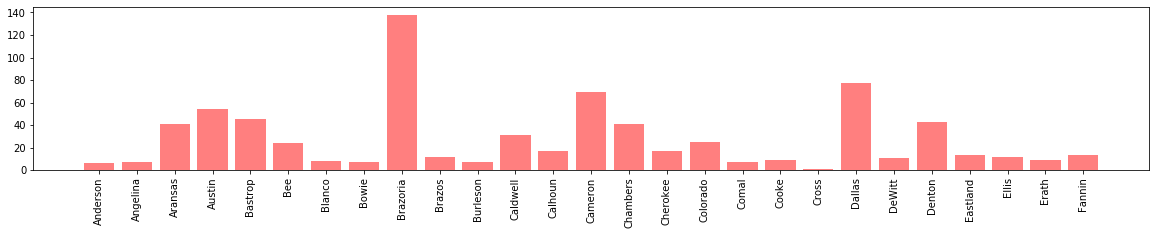

In [21]:
plt.figure(figsize=(20,3))
plt.bar(fema_zillow_mrg["Counties"], fema_zillow_mrg["Disaster"], color='r', alpha=0.5, align="center")
plt.xticks(fema_zillow_mrg["Counties"], rotation="vertical")
#plt.xticks(rotation=90)

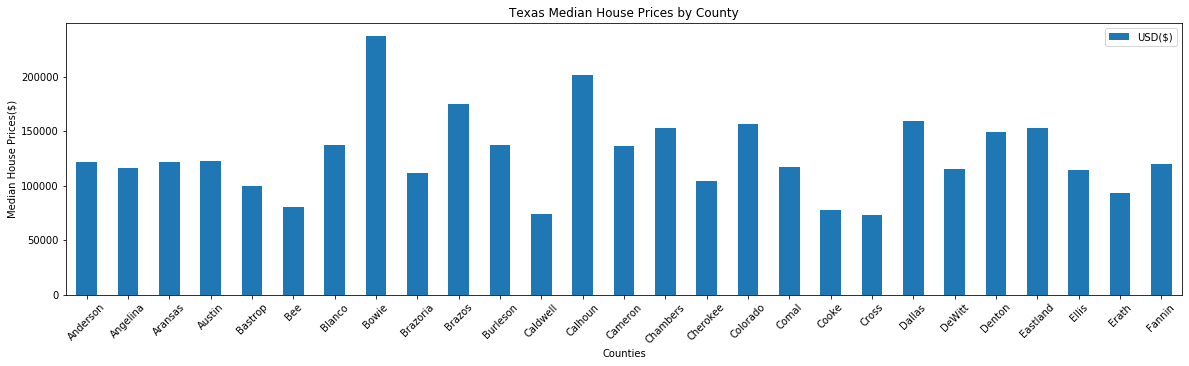

<Figure size 432x288 with 0 Axes>

In [22]:
multi_plot = region_list.plot(kind="bar", figsize=(20,5))

# PandasPlot.set_xticklabels() can be used to set the tick labels as well
multi_plot.set_xticklabels(fema_zillow_mrg["Counties"], rotation=45)
multi_plot.set_xlabel("Counties")
multi_plot.set_ylabel("Median House Prices($)")
multi_plot.set_title("Texas Median House Prices by County")
plt.show()
plt.tight_layout()

In [23]:
#Heat Map of Disaster
locations = fema_zillow_mrg[["latitude", "longitude"]]
weight1 = fema_zillow_mrg["Disaster"]

fig = gmaps.figure(map_type="TERRAIN")

heat_layer = gmaps.heatmap_layer(locations, weights=weight1)
                                #dissipating=False, max_intensity=100)#, point_radius=1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [24]:
# Map of Median House Price vs Disasters in State of Texas

info_box_template = """
<dl>
<dt>Name</dt><dd>{Counties}</dd>
<dt>HomePrice</dt><dd>{USD($)}</dd>
<dt>Disaster</dt><dd>{Disaster}</dd>
</dl>
"""
# Store the DataFrame Row
tx_info = [info_box_template.format(**row) for index, row in fema_zillow_mrg.iterrows()]
locations = fema_zillow_mrg[["latitude", "longitude"]]

# Add marker layer ontop of heat map
markers = gmaps.marker_layer(locations,info_box_content=[f"County: {rate}" for rate in tx_info])
fig.add_layer(markers)
# Display Map
fig

# Display Map

Figure(layout=FigureLayout(height='420px'))